<h2>Transfer Learning 

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow.keras.layers as tfl


from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [56]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_directory = '../datasets/tiny-imagenet-200/train'
validation_directory = '../datasets/tiny-imagenet-200/val'
train_dataset = image_dataset_from_directory(train_directory, 
                                            shuffle=True, 
                                            batch_size=BATCH_SIZE, 
                                            image_size=IMG_SIZE, 
                                            validation_split=0.2,
                                            subset='training',
                                            seed=42)
validation_dataset = image_dataset_from_directory(validation_directory,
                                            shuffle=True,
                                            image_size=IMG_SIZE, 
                                            batch_size=BATCH_SIZE,
                                            validation_split=0.2,
                                            subset='validation',
                                            seed=42)

Found 100000 files belonging to 200 classes.
Using 80000 files for training.
Found 10000 files belonging to 1 classes.
Using 2000 files for validation.


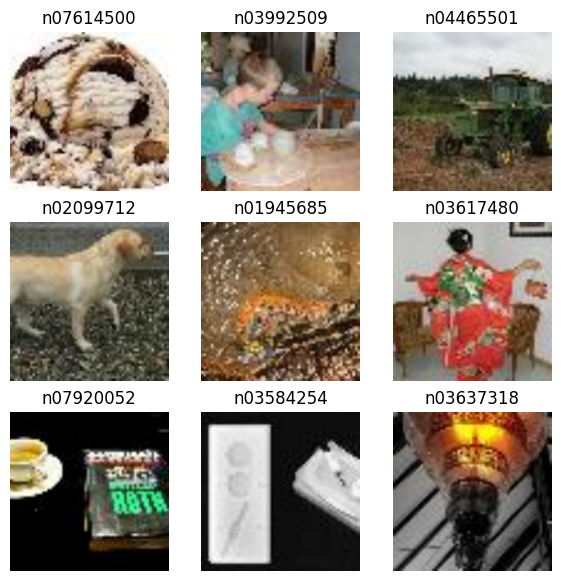

In [57]:
class_names = train_dataset.class_names

plt.figure(figsize=(7, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

<h4>Prefetch</h4>

In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<h4>Augment Data</h4>

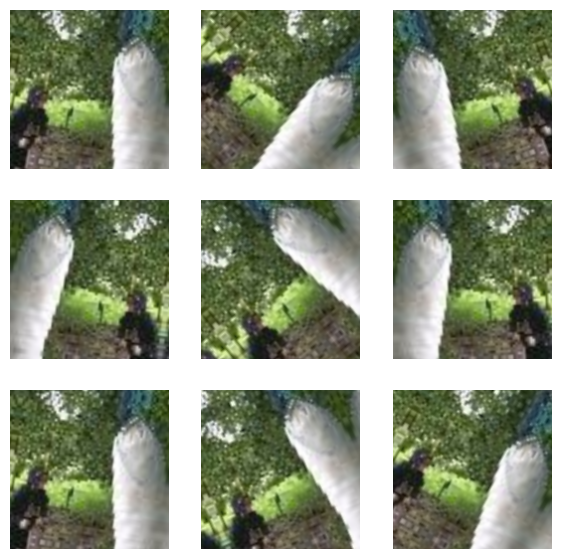

In [59]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

augmenter = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(7, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = augmenter(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

<h3></h3>

In [60]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=True, weights='imagenet')

In [61]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [62]:
image_batch, label_batch = next(iter(train_dataset))
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.29269764),
  ('n02091244', 'Ibizan_hound', 0.094045125)],
 [('n04589890', 'window_screen', 0.64807993),
  ('n03530642', 'honeycomb', 0.021919651)],
 [('n02879718', 'bow', 0.760779), ('n04376876', 'syringe', 0.036017574)],
 [('n04589890', 'window_screen', 0.5420533),
  ('n04258138', 'solar_dish', 0.12178893)],
 [('n04589890', 'window_screen', 0.50006115),
  ('n03347037', 'fire_screen', 0.027682725)],
 [('n04589890', 'window_screen', 0.122103766),
  ('n03733281', 'maze', 0.10304117)],
 [('n04589890', 'window_screen', 0.46309993),
  ('n02095889', 'Sealyham_terrier', 0.048922244)],
 [('n04589890', 'window_screen', 0.6771746),
  ('n04209239', 'shower_curtain', 0.020174665)],
 [('n04589890', 'window_screen', 0.8333233),
  ('n04258138', 'solar_dish', 0.05008258)],
 [('n04589890', 'window_screen', 0.675825),
  ('n04590129', 'window_shade', 0.07303711)],
 [('n04589890', 'window_screen', 0.8192682),
  ('n03995372', 'power_drill', 0.016222224)],
 [('n03347037', 

<h3>Freeze all layers of MobileNetV2 except the Top layer (FC Dense layer) and train it</h3>
<p>First we build the model, define the shapes of the input data and layers<br>
Then we compile the model, define the hyperparameters such as learning rate, type of loss, metrics etc.<br>
Then we <code>.fit</code> (train) the model, data is fed in the model in this stage and epochs is defined</p>

In [63]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    # Make space for 3 color channels i.e RGB therefore adding another dimension of value 3
    input_shape = image_shape + (3,)
    # Define the model, make sure to exclude the top most layer so we can add our own layer and train that particular layer
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    # Freeze the whole model
    base_model.trainable = False
    # I guess this is where we inject the input data, injection point is tf.keras.Input as far as I understand
    inputs = tf.keras.Input(shape=input_shape)
    # augment the input data to make it 9 times
    x = data_augmentation(inputs)
    # Divides the data by 255 to make each pixel value small
    x = preprocess_input(x)
    
    # This training parameter is for batch norm layer, I dont understand how 
    # This is functional api so we can pass parameters like this 
    x = base_model(x, training=False)
    # From here on out we are adding our own layers
    x = tfl.GlobalAveragePooling2D()(x)
    # Dropout to reduce overfitting
    x = tfl.Dropout(0.2)(x)

    # This would be the last layer, also this is the layer which we will train
    prediction_layer = tfl.Dense(1)
    outputs = prediction_layer(x)
    
    # As far as I understand, keras.Model take all the layers between inputs and outputs (both inclusive) 
    # and makes a model out of it
    model = tf.keras.Model(inputs, outputs)

    return model

In [64]:
model2 = alpaca_model(IMG_SIZE, data_augmentation=data_augmenter())

<h4>Compile the model</h4>

In [65]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])

<h4>Train the model</h4>

In [66]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


2500/2500 [==============================] - 83s 32ms/step - loss: -743009.1250 - accuracy: 0.0049 - val_loss: 14239.9600 - val_accuracy: 0.0000e+00
Epoch 2/5
2500/2500 [==============================] - 78s 31ms/step - loss: -2224074.5000 - accuracy: 0.0049 - val_loss: 28455.5293 - val_accuracy: 0.0000e+00
Epoch 3/5
2500/2500 [==============================] - 80s 32ms/step - loss: -3704016.0000 - accuracy: 0.0049 - val_loss: 42665.9609 - val_accuracy: 0.0000e+00
Epoch 4/5
2500/2500 [==============================] - 79s 32ms/step - loss: -5185395.5000 - accuracy: 0.0049 - val_loss: 56883.0195 - val_accuracy: 0.0000e+00
Epoch 5/5
2500/2500 [==============================] - 79s 32ms/step - loss: -6667936.5000 - accuracy: 0.0049 - val_loss: 71098.5469 - val_accuracy: 0.0000e+00


<h4>Loss/Accuracy graph</h4>

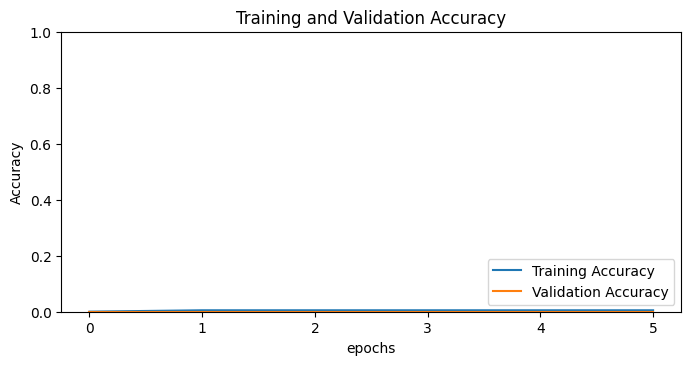

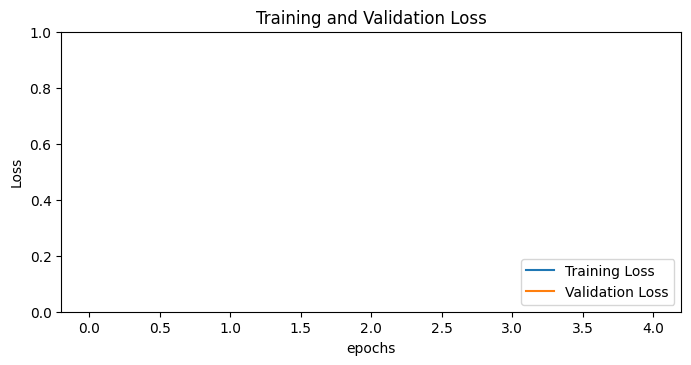

In [70]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('epochs')
plt.show()



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.ylim([0,1.0])
plt.xlabel('epochs')
plt.show()